In [1]:
import pathlib
import tensorflow as tf

# Path to your dataset
data_dir = "C:/Users/abdul/All/OptiMove2/BoardDivider/data_set/training"

# Convert to pathlib.Path object
data_dir = pathlib.Path(data_dir)

# Now data_dir points to your dataset directory


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1171


In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1171 files belonging to 12 classes.
Using 937 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1171 files belonging to 12 classes.
Using 234 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['black_bishop', 'black_king', 'black_knight', 'black_pawn', 'black_queen', 'black_rook', 'white_bishop', 'white_king', 'white_knight', 'white_pawn', 'white_queen', 'white_rook']


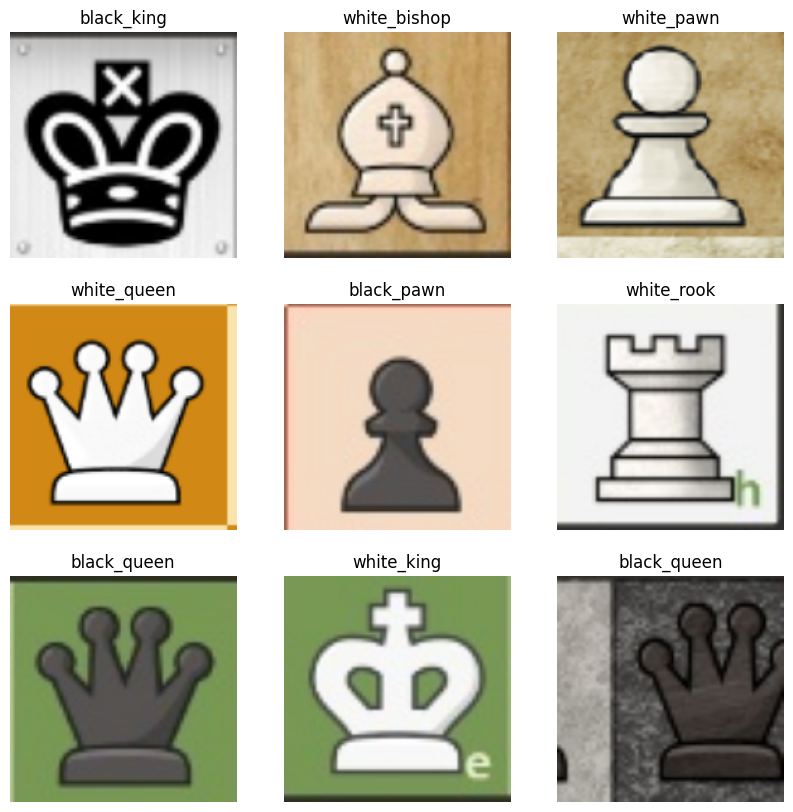

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9999941


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
30/30 [==============================] - 7s 206ms/step - loss: 1.8804 - accuracy: 0.4450 - val_loss: 0.7384 - val_accuracy: 0.7778
Epoch 2/10
30/30 [==============================] - 6s 200ms/step - loss: 0.3580 - accuracy: 0.9018 - val_loss: 0.2398 - val_accuracy: 0.9017
Epoch 3/10
30/30 [==============================] - 6s 201ms/step - loss: 0.1625 - accuracy: 0.9509 - val_loss: 0.2204 - val_accuracy: 0.9316
Epoch 4/10
30/30 [==============================] - 7s 232ms/step - loss: 0.1102 - accuracy: 0.9658 - val_loss: 0.1900 - val_accuracy: 0.9402
Epoch 5/10
30/30 [==============================] - 7s 240ms/step - loss: 0.0529 - accuracy: 0.9808 - val_loss: 0.1773 - val_accuracy: 0.9444
Epoch 6/10
30/30 [==============================] - 7s 242ms/step - loss: 0.0511 - accuracy: 0.9872 - val_loss: 0.1904 - val_accuracy: 0.9530
Epoch 7/10
30/30 [==============================] - 7s 242ms/step - loss: 0.0276 - accuracy: 0.9936 - val_loss: 0.2480 - val_accuracy: 0.9444
Epoch 

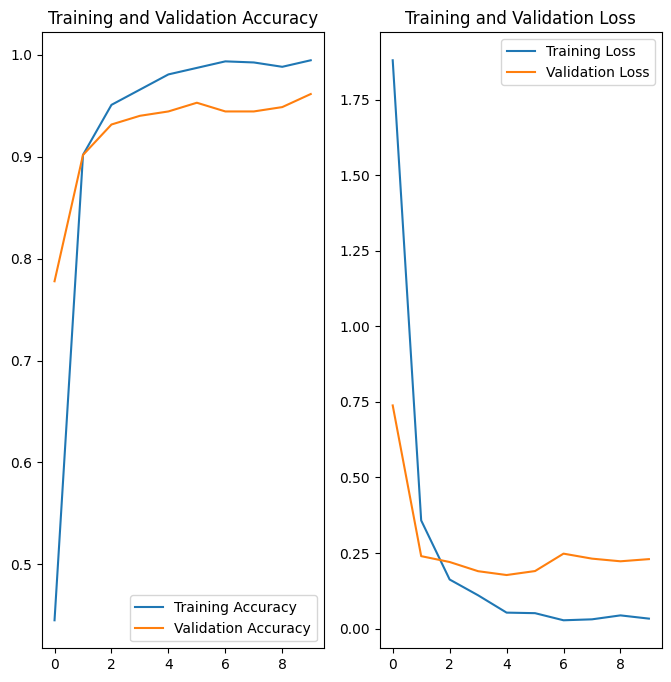

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

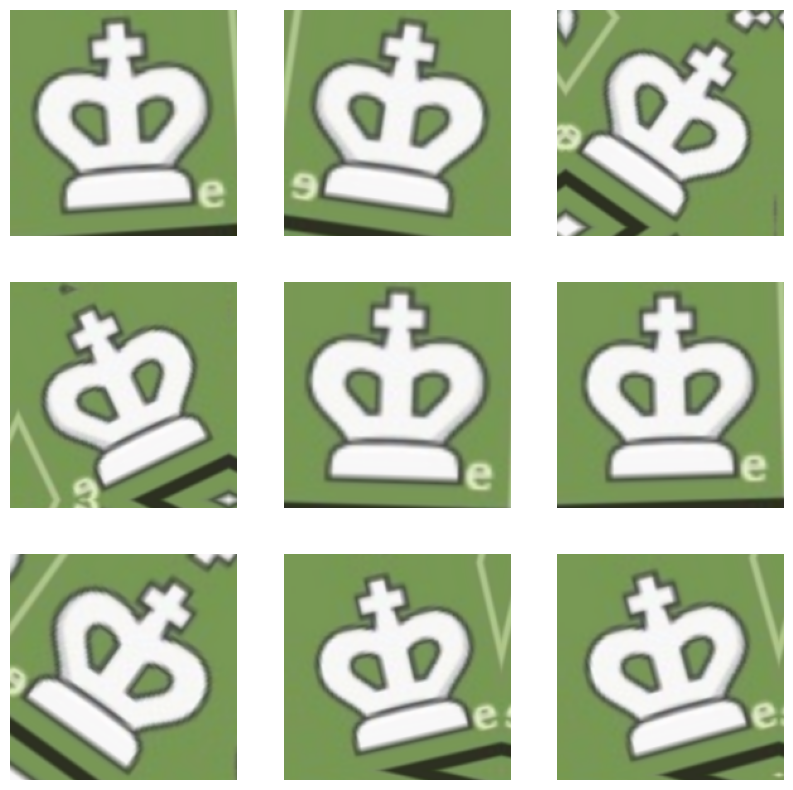

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [23]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
30/30 [==============================] - 10s 274ms/step - loss: 2.6488 - accuracy: 0.1089 - val_loss: 2.3022 - val_accuracy: 0.2094
Epoch 2/15
30/30 [==============================] - 8s 261ms/step - loss: 1.8364 - accuracy: 0.4162 - val_loss: 1.1100 - val_accuracy: 0.6325
Epoch 3/15
30/30 [==============================] - 9s 301ms/step - loss: 0.9376 - accuracy: 0.7172 - val_loss: 0.7836 - val_accuracy: 0.7393
Epoch 4/15
30/30 [==============================] - 11s 352ms/step - loss: 0.6391 - accuracy: 0.8100 - val_loss: 0.5545 - val_accuracy: 0.8077
Epoch 5/15
30/30 [==============================] - 10s 325ms/step - loss: 0.5261 - accuracy: 0.8431 - val_loss: 0.3384 - val_accuracy: 0.8932
Epoch 6/15
30/30 [==============================] - 10s 347ms/step - loss: 0.4326 - accuracy: 0.8751 - val_loss: 0.3985 - val_accuracy: 0.8803
Epoch 7/15
30/30 [==============================] - 10s 327ms/step - loss: 0.3886 - accuracy: 0.8933 - val_loss: 0.3044 - val_accuracy: 0.9060
E

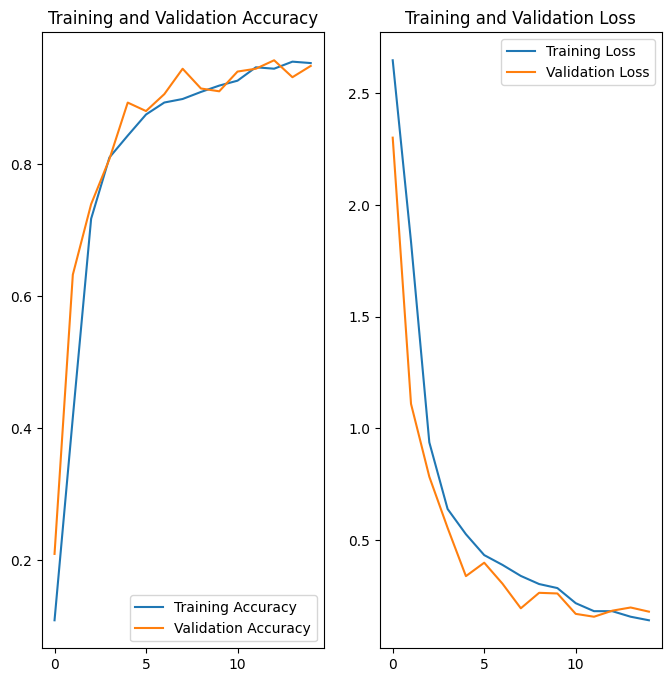

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#... (rest of the code remains the same)

# Convert the model
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    print("Model converted successfully!")
except Exception as e:
    print(f"Error converting model: {e}")
    
    
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
  
  
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

interpreter.get_signature_list()

classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite


INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmp2zngx6z2\assets


INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmp2zngx6z2\assets


Model converted successfully!


INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmptsknfqt9\assets


INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmptsknfqt9\assets


In [26]:
import tensorflow as tf
import numpy as np

# New image path
new_image_path = "../Inputs/image.png"

# Load the image
img = tf.keras.utils.load_img(
    new_image_path, target_size=(180, 180)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Print the result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 78ms/step
This image most likely belongs to black_king with a 99.87 percent confidence.


In [29]:
#... (rest of the code remains the same)

# Convert the model
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    print("Model converted successfully!")
except Exception as e:
    print(f"Error converting model: {e}")
    
    
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmplgmalhjs\assets


INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmplgmalhjs\assets


Model converted successfully!


INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmpr_d31kfp\assets


INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmpr_d31kfp\assets


In [33]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

interpreter.get_signature_list()


{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [35]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

print(np.max(np.abs(predictions - predictions_lite)))

This image most likely belongs to black_king with a 99.87 percent confidence.
1.66893e-05
